# Health Insurance Cross Sell Prediction Predictive Analysis

In [1]:
from data_loader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
train_url = "https://raw.githubusercontent.com/Mkho-cs/HICSP-Predictive-Analysis/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/Mkho-cs/HICSP-Predictive-Analysis/main/dataset/test.csv"
train_data = DataLoader(train_url)
test_data = DataLoader(test_url)

## Data Transformation & EDA

In [3]:
# Data transformation starts here
"""
From the training data description, we can find features that are not important for training.
Hence, drop the following: id, Policy_Sales_Channel
"""
dropped = ['id', 'Policy_Sales_Channel']
train_data.drop_column(dropped)


In [4]:
train_data.display(10, True)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,39,0
5,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,176,0
6,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,249,0
7,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,72,1
8,Female,24,1,3.0,1,< 1 Year,No,27619.0,28,0
9,Female,32,1,6.0,1,< 1 Year,No,28771.0,80,0


In [5]:
"""
Variables can be broadly divided into numerical and categorical
Pandas automatically identifies the data type after loading,
but they are not usually identified as categorical (e.g. 1's and 0's are integers)

Hence, some variables must be coverted manually.
"""
# First, check the types from default data loading
train_data.display_types()

Gender                 object
Age                     int64
Driving_License         int64
Region_Code           float64
Previously_Insured      int64
Vehicle_Age            object
Vehicle_Damage         object
Annual_Premium        float64
Vintage                 int64
Response                int64
dtype: object

In [6]:
# Change selected columns to categorical
cols_to_cat = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
train_data.column_to_cat(cols_to_cat)
train_data.display_types()

Gender                category
Age                      int64
Driving_License       category
Region_Code           category
Previously_Insured    category
Vehicle_Age           category
Vehicle_Damage        category
Annual_Premium         float64
Vintage                  int64
Response              category
dtype: object

In [7]:
# Analysze the frequency of each unique value in respective columns (for categorical variables)
col_unique_freq = train_data.get_col_unique_freq()
for col in col_unique_freq: print(col, '\n')

Gender
Female    175020
Male      206089
dtype: int64 

Driving_License
0       812
1    380297
dtype: int64 

Region_Code
0.0       2021
1.0       1008
2.0       4038
3.0       9251
4.0       1801
5.0       1279
6.0       6280
7.0       3279
8.0      33877
9.0       3101
10.0      4374
11.0      9232
12.0      3198
13.0      4036
14.0      4678
15.0     13308
16.0      2007
17.0      2617
18.0      5153
19.0      1535
20.0      1935
21.0      4266
22.0      1309
23.0      1960
24.0      2415
25.0      2503
26.0      2587
27.0      2823
28.0    106415
29.0     11065
30.0     12191
31.0      1960
32.0      2787
33.0      7654
34.0      1664
35.0      6942
36.0      8797
37.0      5501
38.0      2026
39.0      4644
40.0      1295
41.0     18263
42.0       591
43.0      2639
44.0       808
45.0      5605
46.0     19749
47.0      7436
48.0      4681
49.0      1832
50.0     10243
51.0       183
52.0       267
dtype: int64 

Previously_Insured
0    206481
1    174628
dtype: int64 

Vehicle_A

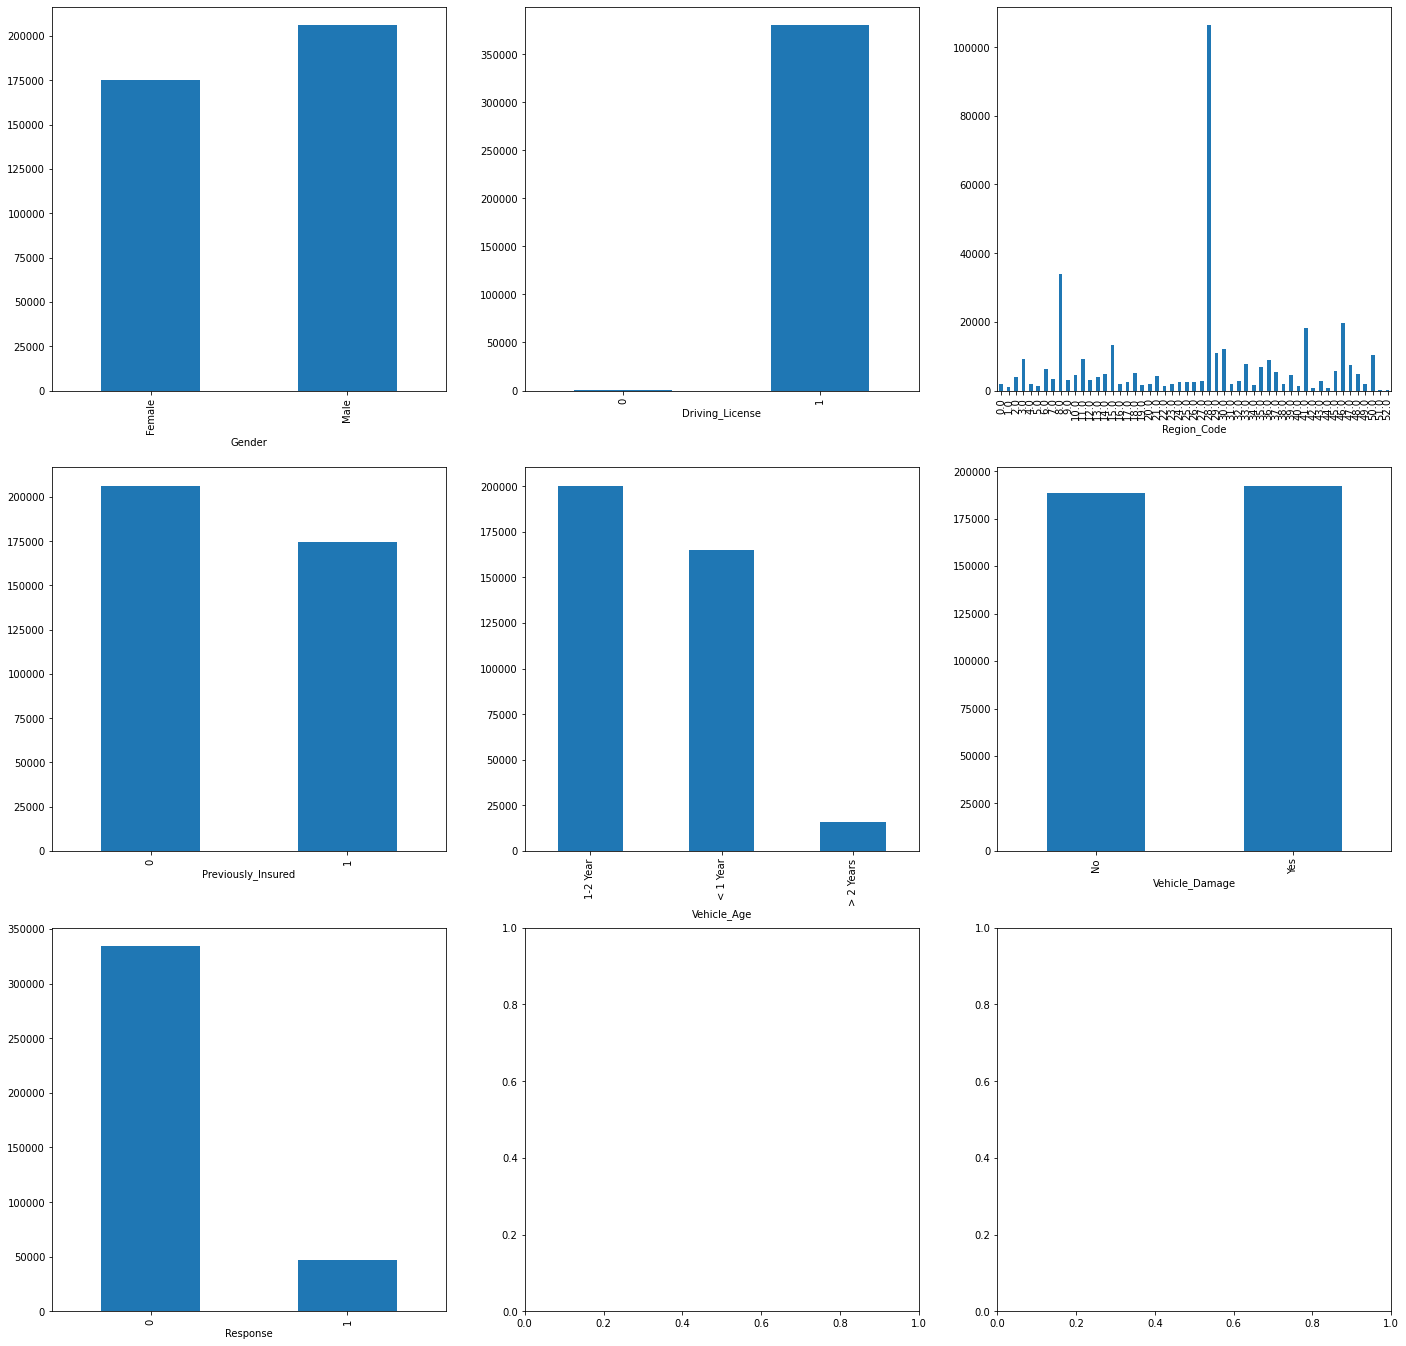

In [8]:
# Distribution plot of categorical columns
"""
The data for categorical variables seems to be well-distributed for the exception of Driving_License
However, upon close inspection on the table form, there is some count of records with Driving_License = 0
Hence, all categorical features here will be used.
"""
train_data.create_subplots(col_unique_freq, 3)


## Prepare Data for Modelling

In [9]:
from sklearn.model_selection import train_test_split
from utils import create_pipeline, create_cat_encoder,create_minmax_scaler, pipeline_fit_transform

In [10]:
y = train_data.data.Response
train_data.drop_column(['Response'])    # remove dependent variable from training

In [11]:
# Training data preparation pipeline
cols_cat = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']
cat_encoder = create_cat_encoder(cols_cat)  # encoder for categorical variables
scaler = create_minmax_scaler() # minmax normalization
prep_pipeline = create_pipeline([("cat_encoder", cat_encoder), ("scaler", scaler)])
train_prep = pipeline_fit_transform(prep_pipeline, train_data.data)


In [12]:
"""
The training dataset is large enough to create a single validation set
Tesing dataset will be used for inference only (there is no 'Response' column)
"""
# Split 75-25 for train-validate sets 
x_train, x_val, y_train, y_val = train_test_split(train_prep, y, random_state=1234) 
print(x_train.shape, x_val.shape, sep='\n')

(285831, 9)
(95278, 9)


## Predictive Modelling

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from utils import evaluate_roc_auc, plot_roc

In [18]:
"""
This section will be mostly experimenting with different predictive models.
The ROC-AUC score metrics will be used since dataset is imbalanced (significant difference of 0's and 1's in Response)
"""
# Predictive modelling starts here
# Initialize models

model_rf_1 = RandomForestClassifier()
model_ada_1 = AdaBoostClassifier()
model_xgb_1 = xgb.XGBClassifier(use_label_encoder=False , objective='binary:logistic', eval_metric='logloss')

train = {0: x_train, 1: y_train}
val = {0: x_val, 1: y_val}

## Train and evaluate models

### Random Forest models

Training score: 0.9999918809477434
Validation score:  0.824477138568131


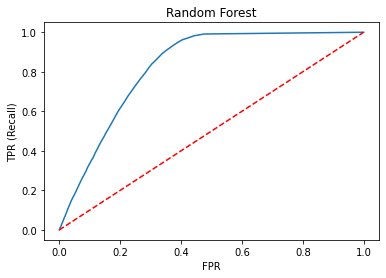

In [15]:

model_rf_1.fit(x_train, y_train)
train_roc_auc, val_roc_auc = evaluate_roc_auc(model_rf_1, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
plot_roc(model_rf_1, val, "Random Forest")

### AdaBoost models

Training score: 0.8463561125617787
Validation score:  0.8474094558591406


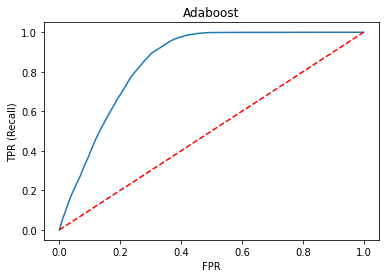

In [16]:
model_ada_1.fit(x_train, y_train)
train_roc_auc, val_roc_auc = evaluate_roc_auc(model_ada_1, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
plot_roc(model_ada_1, val, "AdaBoost")

XGBoost models

[14:30:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training score: 0.8731672534446925
Validation score:  0.8489401296914392


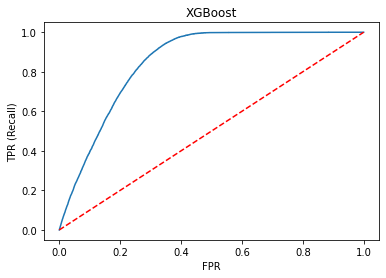

In [19]:
model_xgb_1.fit(x_train, y_train)
train_roc_auc, val_roc_auc = evaluate_roc_auc(model_xgb_1, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
plot_roc(model_xgb_1, val, "XGBoost")